Вариант 12
Лабораторная работа №2. Линейные модели. Кросс-валидация.

В практических примерах ниже показано:

как пользоваться инструментами предварительного анализа для поиска линейных
взаимосвязей;

как строить и интерпретировать линейные модели с логарифмами;

как оценивать точность моделей с перекрёстной проверкой (LOOCV, проверка по блокам).

Модели: множественная линейная регрессия

Данные: https://raw.githubusercontent.com/ania607/ML/main/data/Carseats.csv

Проверка методом K-FOLD, K-VAL = 5;

Зависимая переменная - Sales / продажа (в тысячах штук) в каждом магазине

Независимые переменные:


*   Price / цены компании на автокресла в каждом магазине;
*   Income / уровень дохода сообщества (в тысячах долларов);
*   ShelveLoc / качество стеллажа для размещения автокресел в каждом магазине: Плохое, Хорошее и Среднее.

Задания:
1. Данные своего варианта (см. таблицу ниже) разделить на выборку для построения
моделей (80%) и отложенные наблюдения (20%). Оставить в таблице только указанные в
варианте переменные. Отложенные наблюдения использовать только в задании 6.
2. Провести предварительный анализ данных с помощью описательных статистик и
графиков, оценить взаимосвязь.
3. Проверить Y на нормальность. Если он распределён не по нормальному закону,
прологарифмировать и снова провести анализ взаимосвязей переменных.
4. Составить список возможных спецификаций моделей множественной регрессии (на
исходной Y и на логарифме Y ).
5. Оценить параметры моделей из списка. Оценить точность моделей методом
перекрёстной проверки, указанным в варианте. Найти самую точную из моделей для Y .
Найти самую точную из моделей для log(Y ).
6. Сделать прогноз с помощью самых точных моделей на отложенные наблюдения.
Рассчитать MSEtest вручную и выбрать одну наиболее точную модель. Проинтерпретировать её параметры.

Задание 1. Решение.

Загрузим все необходимые для работы модули, определим константы и загрузим входные данные. Во входных данных отфильтруем только необходимые нам для работы признаки.

Определим фиктивные переменные для качественного признака и объединим их с исходными данными.

Разделим исходную выборку на тренировочную и тестовую.

In [68]:
# Загрузка модулей
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import shapiro
import numpy as np
import time
from scipy.stats import shapiro
from sklearn import linear_model as skl_lm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [69]:
# Загрузка констант и глобальных настроек
SEED = 12
TRAIN_FRAC = 0.8
K_VAL = 5
ALPHA = 0.05
sns.set_style("whitegrid")
sns.set_palette("flare")

In [70]:
# Загрузка входящих данных
fileUrl = "https://raw.githubusercontent.com/ania607/ML/main/data/Carseats.csv"
df_raw = pd.read_csv(fileUrl)
df_raw = df_raw[["Income", "Price", "ShelveLoc", "Sales"]]

In [71]:
df_raw

,Income,Price,ShelveLoc,Sales
0,73,120,Bad,9.50
1,48,83,Good,11.22
2,35,80,Medium,10.06
3,100,97,Medium,7.40
4,64,128,Bad,4.15
...,...,...,...,...
395,108,128,Good,12.57
396,23,120,Medium,6.14
397,26,159,Medium,7.41
398,79,95,Bad,5.94


In [72]:
df_raw.isna().sum()

Income       0
Price        0
ShelveLoc    0
Sales        0
dtype: int64

In [73]:
# Создание фиктивных переменных
df_dummy = pd.get_dummies(df_raw["ShelveLoc"], drop_first = True)
df_dummy.head()

,Good,Medium
0,0,0
1,1,0
2,0,1
3,0,1
4,0,0


In [74]:
# Объединение данных
df_all = pd.concat([df_raw, df_dummy], axis=1)

In [75]:
df_all

,Income,Price,ShelveLoc,Sales,Good,Medium
0,73,120,Bad,9.50,0,0
1,48,83,Good,11.22,1,0
2,35,80,Medium,10.06,0,1
3,100,97,Medium,7.40,0,1
4,64,128,Bad,4.15,0,0
...,...,...,...,...,...,...
395,108,128,Good,12.57,1,0
396,23,120,Medium,6.14,0,1
397,26,159,Medium,7.41,0,1
398,79,95,Bad,5.94,0,0


In [76]:
# Замена качественных данных количественными (для отображения на графиках)
class_le = LabelEncoder()
df_all["ShelveLoc"] = class_le.fit_transform(df_all["ShelveLoc"].values)

In [77]:
df_all

,Income,Price,ShelveLoc,Sales,Good,Medium
0,73,120,0,9.50,0,0
1,48,83,1,11.22,1,0
2,35,80,2,10.06,0,1
3,100,97,2,7.40,0,1
4,64,128,0,4.15,0,0
...,...,...,...,...,...,...
395,108,128,1,12.57,1,0
396,23,120,2,6.14,0,1
397,26,159,2,7.41,0,1
398,79,95,0,5.94,0,0


In [78]:
# Разделение данных на тренировочные и тестовые
df_train = df_all.sample(frac = TRAIN_FRAC, random_state = SEED)
df_test = df_all.drop(df_train.index).sample(frac = 1, random_state = SEED)

In [79]:
df_train, df_test

(     Income  Price  ShelveLoc  Sales  Good  Medium
 280      86    145          0   2.86     0       0
 387      73    115          2   8.67     0       1
 313      81     54          2   9.33     0       1
 1        48     83          1  11.22     1       0
 35       84     96          2  11.07     0       1
 ..      ...    ...        ...    ...   ...     ...
 347      39    112          1   6.88     1       0
 377      61    125          2   6.81     0       1
 91       46    107          2   4.81     0       1
 114      87    106          2   9.31     0       1
 70       81     99          1   9.46     1       0
 
 [320 rows x 6 columns],
      Income  Price  ShelveLoc  Sales  Good  Medium
 274      93    119          2   7.22     0       1
 89       66    119          2   7.95     0       1
 104      96    138          2   4.62     0       1
 65       26    128          2   4.90     0       1
 203      82    157          0   2.05     0       0
 ..      ...    ...        ...    ...

In [80]:
df_train[["Income", "Price", "Sales"]].describe()

,Income,Price,Sales
count,320.000000,320.000000,320.000000
mean,68.490625,115.762500,7.536812
std,28.206025,24.133767,2.840746
min,21.000000,24.000000,0.000000
25%,43.500000,100.000000,5.527500
50%,68.500000,117.000000,7.545000
75%,91.250000,131.000000,9.332500
max,120.000000,191.000000,16.270000


Задание 1. Результаты.

Мы получили две выборки: тренировочную и тестовую, содержащие необходимые для работы данные.

Задание 2. Решение.

Проведем предварительный анализ данных на тренировочной выборке:

*   Построим гистограммы распределения и графики зависимости количественных переменных;
*   Построим гистограммы распределения и графики зависимости количественных переменных для разных значений качественной переменной;
*   Построим матрицу корреляции количественных переменных;
*   Построим матрицу корреляции количественных переменных для разных значений качественной переменной.



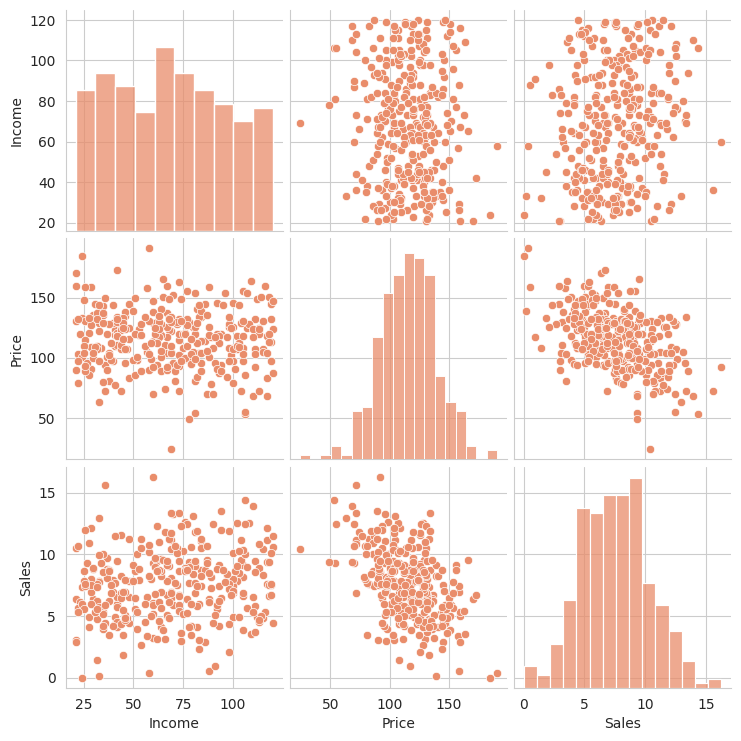

In [81]:
# Распределение и зависимость количественных данных
sns.pairplot(df_train[["Income", "Price", "Sales"]])
plt.show()

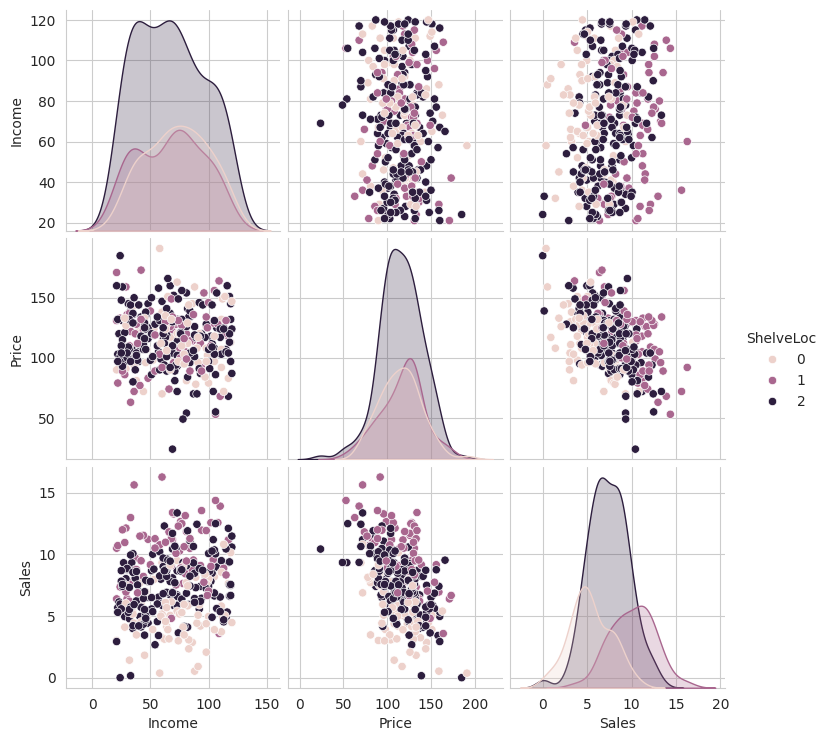

In [82]:
# Распределение и зависимость количественных данных (разделенных по качественному признаку)
sns.pairplot(df_train[["Income", "Price", "Sales", "ShelveLoc"]], hue = "ShelveLoc")
plt.show()

In [83]:
# Корреляционная матрица количественных данных
corr_mat = df_train[["Income", "Price", "Sales"]].corr()
corr_mat.style.background_gradient(cmap="coolwarm").format(precision=2)

,Income,Price,Sales
Income,1.00,-0.07,0.16
Price,-0.07,1.00,-0.48
Sales,0.16,-0.48,1.00


In [84]:
# Корреляционная матрица количественных данных (для качественного стеллажа)
corr_mat = df_train[df_train["Good"] == 1][["Income", "Price", "Sales"]].corr()
corr_mat.style.background_gradient(cmap="coolwarm").format(precision=2)

,Income,Price,Sales
Income,1.00,0.02,0.11
Price,0.02,1.00,-0.68
Sales,0.11,-0.68,1.00


In [85]:
# Корреляционная матрица количественных данных (для нормального стеллажа)
corr_mat = df_train[df_train["Medium"] == 1][["Income", "Price", "Sales"]].corr()
corr_mat.style.background_gradient(cmap="coolwarm").format(precision=2)

,Income,Price,Sales
Income,1.00,-0.12,0.32
Price,-0.12,1.00,-0.59
Sales,0.32,-0.59,1.00


Задание 2. Результаты.

По гистограмме распределения "Sales" можно сделать предположение, что данные распределены нормально.

По графикам распределения видно, что переменная "Sales" слабо зависит от "Income" и сильно обратно зависима от переменной "Price". Это подтверждается матрицей корреляции.

Разные значения качественной переменной "ShelveLoc" заметно влияют на среднее значения распределения переменной "Sales".

По матрицам корреляции видно, что значение переменной "ShelveLoc" == "Good" усиливает коррелированность "Price" и "Sales", а значение переменной "ShelveLoc" == "Medium" усиливает коррелированность "Income" и "Sales".

Задание 3. Решение.

Проверим распределение переменной "Sales" на нормальность при помощи теста Шапиро-Уилка. Если распределение не является нормальным, проверим логарифм переменной на нормальность.

In [86]:
# Проверка нормальности распределения продаж
stat, p = shapiro(df_train["Sales"])
print(f"Statistics = {stat}, p = {p}")
if p > ALPHA:
  print("Распределение нормально (H0 не отклоняется)")
else:
  print("Распределение не нормально (H0 отклоняется)")

Statistics = 0.9963723421096802, p = 0.681464433670044
Распределение нормально (H0 не отклоняется)


In [87]:
# Логарифмирование продаж
df_train["Sales_log"] = np.log(df_train["Sales"])

df_train[["Sales", "Sales_log", "Income", "Price", "Medium", "Good"]].describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Sales,Sales_log,Income,Price,Medium,Good
count,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,7.536812,-inf,68.490625,115.762500,0.534375,0.231250
std,2.840746,NaN,28.206025,24.133767,0.499598,0.422292
min,0.000000,-inf,21.000000,24.000000,0.000000,0.000000
25%,5.527500,1.709735,43.500000,100.000000,0.000000,0.000000
50%,7.545000,2.020883,68.500000,117.000000,1.000000,0.000000
75%,9.332500,2.233503,91.250000,131.000000,1.000000,0.000000
max,16.270000,2.789323,120.000000,191.000000,1.000000,1.000000


Задание 3. Результаты.

Мы определили, что распределение переменной "Sales" является нормальным.

Так как исходные данные обладают значениями "Sales" == 0, а также так как мы уже подтвердили нормальность переменной "Sales", логарифм переменной "Sales" далее рассматриваться не будет.

Задание 4. Решение. Результаты.

В соответствии с результатами задания 2 можно составить следующие линейные спецификации модели:

1.   Sales = Income + Price + Medium + Good
2.   Sales = Income + Price * Good + Medium + Good
3.   Sales = Income * Medium + Price  + Medium + Good
4.   Sales = Income * Medium + Price * Good + Medium + Good

В соответствии с результатами задания 3, показательные модели рассматриваться не будут.

Задание 5. Решение.

Построим модели, определенные в задании 4.

Определим параметры моделей и оценим их точность методом K-FOLDS (K-VAl = 5).

Найдем самую точную из моделей.

In [88]:
df1 = df_train[["Sales", "Income", "Price", "Medium", "Good"]]

df2 = df_train[["Sales", "Income", "Price", "Medium", "Good"]]
df2.loc[:, "Price_Good"] = df2.loc[:, "Price"] * df2.loc[:, "Good"]
df2 = df2.drop(["Price"], axis = 1)

df3 = df_train[["Sales", "Income", "Price", "Medium", "Good"]]
df3.loc[:, "Income_Medium"] = df3.loc[:, "Income"] * df3.loc[:, "Medium"]
df3 = df3.drop(["Income"], axis = 1)

df4 = df_train[["Sales", "Income", "Price", "Medium", "Good"]]
df4.loc[:, "Price_Good"] = df4.loc[:, "Price"] * df4.loc[:, "Good"]
df4.loc[:, "Income_Medium"] = df4.loc[:, "Income"] * df4.loc[:, "Medium"]
df4 = df4.drop(["Income", "Price"], axis = 1)

<ipython-input-88-18bd4c29e6df>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, "Price_Good"] = df2.loc[:, "Price"] * df2.loc[:, "Good"]
<ipython-input-88-18bd4c29e6df>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.loc[:, "Income_Medium"] = df3.loc[:, "Income"] * df3.loc[:, "Medium"]
<ipython-input-88-18bd4c29e6df>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [89]:
df4

,Sales,Medium,Good,Price_Good,Income_Medium
280,2.86,0,0,0,0
387,8.67,1,0,0,73
313,9.33,1,0,0,81
1,11.22,0,1,83,0
35,11.07,1,0,0,84
...,...,...,...,...,...
347,6.88,0,1,112,0
377,6.81,1,0,0,61
91,4.81,1,0,0,46
114,9.31,1,0,0,87


In [90]:
# Оценка точностей моделей методом K-FOLD(5).
lm = skl_lm.LinearRegression()
folds = K_VAL

r_state = np.arange(SEED, SEED + K_VAL - 1)

scores = list()
tic = time.perf_counter()
for i, df in enumerate([df1, df2, df3, df4]):
  x = df.drop(["Sales"], axis = 1)
  y = df["Sales"]
  kf_5 = KFold(n_splits = folds, random_state = r_state[i],
                shuffle = True)
  score = cross_val_score(lm, x, y, cv = kf_5, scoring = "neg_mean_squared_error").mean()
  scores.append(score)
toc = time.perf_counter()
print(f"Расчёты методом CV по 5 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 5 блокам заняли 0.16 секунд


In [91]:
scores

[-3.3744484382117954,
 -4.618071930327842,
 -3.387965894481904,
 -4.662649381881958]

In [92]:
# Выбор наилучшей модели
fits = ["model1", "model2", "model3", "model4"]
print("Наименьшая ошибка методом k-fold5 у модели",
      fits[scores.index(max(scores))],
      ":\nMSE_kf5 =", np.around(-max(scores), 0))

Наименьшая ошибка методом k-fold5 у модели model1 :
MSE_kf5 = 3.0


Задание 5. Результаты.

Мы определили, что наименьшую ошибку методом K-FOLDS (K-VAL = 5) выдает модель №1:

Sales = Income + Price + Medium + Good



Задание 6. Решение.

Сделаем прогноз первой моделью на тестовые данные и оценим полученную ошибку тестирования. Оценим среднюю ошибку модели.

Построим первую модель на всех данных и проинтерпретируем ее параметры.

In [93]:
# Проверка качества модели на тестовых данных
x = df1.drop(["Sales"], axis=1)
y = df1[["Sales"]].values.reshape(-1, 1)
model1 = lm.fit(x, y)

y = df_test[["Sales"]].values.reshape(-1, 1)
x = df_test[["Income", "Price", "Medium", "Good"]]
y_pred = model1.predict(x)

MSE = sum((y - y_pred.reshape(-1, 1)) ** 2) / len(y)
print(f"MSE модели model1 на тестовых наблюдениях = {MSE[0]:.2f}")

MSE модели model1 на тестовых наблюдениях = 4.25


In [94]:
# Оценка средней ошибки модели в процентах
print("Ошибка модели на отложенных наблюдениях составила ",
      np.around(np.sqrt(MSE) / np.mean(y) * 100, 1)[0],
      "% от среднего значения Y",
      sep = "")

Ошибка модели на отложенных наблюдениях составила 28.1% от среднего значения Y


In [95]:
# Построение финальной модели на всех данных
x = df_all.drop(["Sales", "ShelveLoc"], axis=1)
y = df_all[["Sales"]].values.reshape(-1, 1)
model1 = lm.fit(x, y)

print("модель model1:\n",
      "константа ", np.around(model1.intercept_, 3),
      "\n объясняющие ", list(x.columns.values),
      "\n коэффициенты ", np.around(model1.coef_, 3))


модель model1:
 константа  [10.78] 
 объясняющие  ['Income', 'Price', 'Good', 'Medium'] 
 коэффициенты  [[ 0.015 -0.056  4.958  1.936]]


Задание 6. Результаты.

Средняя ошибка  модели (построенной на тренировочных данных) равна 28.1% от среднего значения "Sales".

В результате построения на всех данных была получена модель:

Sales = 0.015 * Income - 0.056 * Price + 4.958 * Good + 1.936 * Medium

Ее параметры можно интерпретировать следующим образом:

1.   При увеличении прибыли покупателей на 1 тыс. долларов, число продаж в среднем увеличится на 15 штук. Значит, приоритетной является работа с более состоятельными клиентами.
2.   При увеличении цены кресел на 1 доллар, число продаж в среднем падает на 56 штук. Соотвественно, увеличение цены понижает продажи товара.
3.   Качество стеллажа для размещения автокресел влияет на их продажи: продажи кресел на хороших стеллажах были выше на 3022 штук, а на плохих были ниже на 1936 штук (относительно среднего качества стеллажа).



